<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-Data" data-toc-modified-id="Get-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get Data</a></span><ul class="toc-item"><li><span><a href="#Data-Checks" data-toc-modified-id="Data-Checks-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Checks</a></span></li></ul></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Clean Data</a></span><ul class="toc-item"><li><span><a href="#Clean-source-column" data-toc-modified-id="Clean-source-column-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clean source column</a></span></li><li><span><a href="#Clean-Age-Columns" data-toc-modified-id="Clean-Age-Columns-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Clean Age Columns</a></span></li></ul></li><li><span><a href="#Clean-columns" data-toc-modified-id="Clean-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clean columns</a></span><ul class="toc-item"><li><span><a href="#Drop-unused-columns" data-toc-modified-id="Drop-unused-columns-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Drop unused columns</a></span></li><li><span><a href="#Fix-column-types-and-names" data-toc-modified-id="Fix-column-types-and-names-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fix column types and names</a></span></li></ul></li><li><span><a href="#Add-trial_no" data-toc-modified-id="Add-trial_no-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add trial_no</a></span><ul class="toc-item"><li><span><a href="#Save-data" data-toc-modified-id="Save-data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save data</a></span></li></ul></li><li><span><a href="#Descriptive-Stats" data-toc-modified-id="Descriptive-Stats-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Descriptive Stats</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Meta-Info" data-toc-modified-id="Meta-Info-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Meta Info</a></span></li><li><span><a href="#Sources" data-toc-modified-id="Sources-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Sources</a></span></li></ul></li><li><span><a href="#Desc-Stat-Tables" data-toc-modified-id="Desc-Stat-Tables-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Desc Stat Tables</a></span></li><li><span><a href="#Desc-Stat-Plots" data-toc-modified-id="Desc-Stat-Plots-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Desc Stat Plots</a></span></li></ul></li><li><span><a href="#Race-conditions/trials" data-toc-modified-id="Race-conditions/trials-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Race conditions/trials</a></span></li></ul></div>

# Get Data

In [104]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np 


def query_database(query):
    query_job = client.query(query)
    df = query_job.to_dataframe()
    return df 

key_path = f"../../secrets/google_creds.json"
credentials = service_account.Credentials.from_service_account_file(key_path,
                                                                    scopes=[
                                                                        "https://www.googleapis.com/auth/cloud-platform"], )
client = bigquery.Client(credentials=credentials, project=credentials.project_id)
first_query = """SELECT * FROM
`net_expr.trials` AS t
INNER JOIN `net_expr.person` as p
ON t.participant_id = p.participant_id
WHERE 
p.is_test is FALSE AND 
p.participant_id != 'seed' AND
world <= 6 AND 
t.response_date <= '2023-07-26T19:19:04'
"""
df = query_database(first_query)

# Filter data

## Filter out er_ids

In [105]:
er_ids = ['dbe96241-4d64-4ae6-bb6d-15e5e45b0760', 'e6fdd18f-de53-4159-965a-656aa75ba88d']
df = df.query("response_id not in @er_ids")

## Filter out false positive profanity

In [106]:
df2 = df.copy()
profane_df2 = df2[df2['is_profane'] == True]
for index, x in profane_df2.iterrows():
    pass
    #print(x['response_id'], x['response_text'])
fp = ['2e834786-dbbb-422e-975c-bb35d4418fa4', 
      '23b9ec2f-4a71-46cc-bd49-ec7de18ed184', 
      'c376d9e1-3d51-486a-a914-4e5c8a2a6453',
      '9ea1c436-1d8a-4b8f-b7b4-74729c3997d6',
      '7489e80a-65b9-4d14-b260-67908c35b4b4',
      'cf5c2549-6c72-4532-8355-9de800655df6',
      'a44e3014-b960-409a-85d5-b91e195bc6da',
      '4582d0a8-d5e1-4eed-bc40-5552eaf1a790',
      'c961cc7c-6d6e-44fd-86fc-93bc9f213854',
      'd6756b75-e0ed-4f56-bead-ab9df2ab5c12']
tp = [x for x in profane_df2['response_id'] if x not in fp]
assert len(tp) + len(fp) == len(profane_df2), "TP + FP don't add up"
print(f"There were {len(profane_df2)} ideas labled as profane. {len(fp)} were false positives. We drop the true positives (n={len(tp)}).")

# Now change profane field for the false positives in a new column called is_profane2
df['is_profane2'] = df['is_profane']  
df.loc[df['response_id'].isin(fp), 'is_profane2'] = False
assert np.sum(df['is_profane2']) == len(tp), "Mismatch: {Profane2} not equal to {profane} - {fp}"

# Drop the true positives
df = df[df['is_profane2'] == False]
len(df)

There were 46 ideas labled as profane. 10 were false positives. We drop the true positives (n=36).


3408

## Data Checks

In [107]:
def verify_rid_unique():
    print("TEST: Does every response id occur only once?")
    unique_rds = len(df['response_id'].unique())
    all_rids = len(df['response_id'].tolist())
    if all_rids == unique_rds:
        print("YES: Every response id only occurs once")
    else:
        print("NO: Some response ids occur twice")
    
    
def verify_no_response_blank():
    print("TEST: Is it the case that all response texts have some words")
    blanks = len([x for x in df['response_id'].tolist() if x is None])
    if blanks == 0:
        print("YES: All responses have some words")
    else:
        print("NO: Some responses don't have words")
    
        
verify_rid_unique()
print()
verify_no_response_blank()

TEST: Does every response id occur only once?
YES: Every response id only occurs once

TEST: Is it the case that all response texts have some words
YES: All responses have some words


# Clean Data

## Clean source column

We tracked where traffic came from by appending different things to the request arguments for the experiment site. E.g: If posting the experiment on Facebook we would make the URL `experiment.com?from=facebook` so then `request_args` would be equal to `from=facebook`. But in some cases, no `request args` are available. This happens if somehow the request_args are stripped. There should be very few cases of this. 

In [108]:
def verify_other_source():
    print("TEST: Does every source marked as OTHER have no request args?")
    other_request_args = df.query("source=='other'")['request_args'].tolist()
    len_other = len(other_request_args)
    len_other_no_args = len([x for x in other_request_args if x == 'None'])
    if len_other == len_other_no_args:
        print("YES: For every source marked as `other`, we marked it as `other` because it does not have request args")
    else:
        print("NO: We missed categorizing some sources")
    
    

def categorize_request_args(request_args):
    request_args = request_args.lower()
    if 'facebook' in request_args:
        return 'facebook'
    elif 'chatgpt' in request_args:
        return 'r/chatgpt'
    elif 'sample' in request_args:
        return 'r/samplesize'
    elif 'writing' in request_args:
        return 'r/writing'
    elif 'internet' in request_args:
        return 'r/InternetIsBeautiful'
    elif 'creative' in request_args:
        return 'Creative Mornings newsletter'
    elif 'poetry' in request_args:
        return 'r/poetry'
    elif 'results' in request_args or 'share' in request_args:
        return 'share'
    elif "ai" in request_args:
        return "r/artificial"
    elif "singular" in request_args:
        return "r/singularity"
    else:
        return 'other'

df['source'] = df['request_args'].apply(categorize_request_args)
verify_other_source()

df['source'].value_counts()

TEST: Does every source marked as OTHER have no request args?
YES: For every source marked as `other`, we marked it as `other` because it does not have request args


Creative Mornings newsletter    1466
r/InternetIsBeautiful           1115
r/samplesize                     389
share                            248
r/chatgpt                         79
r/writing                         30
r/artificial                      24
other                             22
r/poetry                          15
r/singularity                     13
facebook                           7
Name: source, dtype: int64

## Clean Age Columns
Participants entered their age, which was an int that had to be over 18. But let's make sure nobody entered anything weird -- and by weird we will look at responses over 70 years old. From inspecting the data, it appears that responses above 74 are troll responses -- relabel as NA and report in paper. 

In [109]:
dfp = df.drop_duplicates(subset=['participant_id'])
dfp['age'].describe()

count    674.000000
mean      36.810089
std       28.739898
min       18.000000
25%       27.000000
50%       34.000000
75%       40.000000
max      444.000000
Name: age, dtype: float64

In [110]:
over_seven = dfp[dfp['age']>=70]
over_seven

,response_id,participant_id,response_text,response_date,condition,condition_order,item,world,init_array,ranked_array,...,age,is_test_1,referer,request_args,is_prolific_1,prolific_id,gender,gender_describe,is_profane2,source
755,2e5141b6-814c-4e5f-89f6-9fe6155915e3,7f067979-5f4b-4729-a61f-827d82f929ff,Building a straw ball house,2023-07-14 03:00:50,f_u,0,tire,3,"[723fd22b-6121-4935-82a1-54dfcecec5d9, e7726b1...","[a01068a1-ea4a-4c84-b9df-082ed1fe1b54, fd61a41...",...,74,False,None,from=news&sub=creative&mc_cid=5c0a1bc1ef&mc_ei...,False,None,prefer_self_describe,She/her/they,False,Creative Mornings newsletter
1938,5c366ee2-b272-454b-8f5f-b4b6e54e67b1,b2269ab4-bc4b-4049-b234-e240644e2cf7,to make into a bicycle tire made out of shoes,2023-07-08 17:26:18,h,0,shoe,3,"[human_seed39_world3, human_seed37_world3, hum...","[human_seed38_world3, human_seed40_world3, hum...",...,420,False,https://createwithai.herokuapp.com/results/1b7...,how=results,False,None,prefer_not_disclose,None,False,share
2092,d2d498ec-58a0-4286-bb03-e4aa50f0486a,4c7db1ec-9ae0-4b58-b4d3-8186d5599d90,Portable cell-phone,2023-07-08 15:21:19,f_l,0,shoe,1,"[43d81087-73e7-41ba-949d-0041d1cd8811, f8ecf73...","[43d81087-73e7-41ba-949d-0041d1cd8811, f8ecf73...",...,432,False,https://www.reddit.com/,from=reddit&sub=internet,False,None,man,None,False,r/InternetIsBeautiful
2250,4735ccd1-f9b8-4d39-a115-5ea58265e0a2,8459a1e8-f7a7-46b1-82a2-0d99056ac3f4,store krabby patty secret formula,2023-07-08 15:49:57,f_l,0,bottle,1,"[d2a4126d-b581-4cb9-ba80-60dfc39d227b, 36b21de...","[d6829192-dce2-4a9d-9d46-e836acd74201, 36b21de...",...,444,False,https://www.reddit.com/,from=reddit&sub=internet,False,None,prefer_not_disclose,None,False,r/InternetIsBeautiful
3018,cde0fcff-bf2b-45b7-bcd5-a32386664c8f,ae94364d-2fb8-47d0-b909-1c9e0d97aeff,Cut legs off to use as shorts,2023-07-08 15:05:43,m_l,0,pants,0,"[ai_seed562, f28fb317-4ea6-418f-9040-dd180452c...","[ai_seed304, f28fb317-4ea6-418f-9040-dd180452c...",...,111,False,https://out.reddit.com/,from=reddit&sub=internet,False,None,man,None,False,r/InternetIsBeautiful


In [111]:
print(dfp[dfp['age']>74][['participant_id', 'age']].to_latex(caption="Users whose age we replaced with missing"))

\begin{table}
\centering
\caption{Users whose age we replaced with missing}
\begin{tabular}{llr}
\toprule
{} &                        participant\_id &  age \\
\midrule
1938 &  b2269ab4-bc4b-4049-b234-e240644e2cf7 &  420 \\
2092 &  4c7db1ec-9ae0-4b58-b4d3-8186d5599d90 &  432 \\
2250 &  8459a1e8-f7a7-46b1-82a2-0d99056ac3f4 &  444 \\
3018 &  ae94364d-2fb8-47d0-b909-1c9e0d97aeff &  111 \\
\bottomrule
\end{tabular}
\end{table}



In [112]:
def fix_age(x):
    if pd.isnull(x):  # Check for NaN values
        return x
    elif x <= 74:
        return int(x)
    else:
        return np.NaN

df['age'] = df['age'].apply(lambda x: fix_age(x))
df['age'] = df['age'].astype('Int64')
df['age'].describe()

count    2739.000000
mean       35.099671
std        10.778360
min        18.000000
25%        27.000000
50%        34.000000
75%        40.000000
max        74.000000
Name: age, dtype: float64

# Clean columns

## Drop unused columns

Note `is_troll` was not used; the relevant column is `is_profane`. 

In [113]:
df.columns

Index(['response_id', 'participant_id', 'response_text', 'response_date',
       'condition', 'condition_order', 'item', 'world', 'init_array',
       'ranked_array', 'is_test', 'duration', 'is_troll', 'is_profane',
       'is_prolific', 'participant_id_1', 'creativity_human', 'creativity_ai',
       'dt', 'ai_feeling', 'country', 'age', 'is_test_1', 'referer',
       'request_args', 'is_prolific_1', 'prolific_id', 'gender',
       'gender_describe', 'is_profane2', 'source'],
      dtype='object')

In [115]:
to_drop = ["is_prolific", "is_prolific_1", "prolific_id", "is_test_1", "is_troll", "dt", 'participant_id_1']
for x in to_drop:
    try:
        df = df.drop(columns = [x], axis=0)
    except KeyError:
        pass

## Fix column types and names

In [116]:
df['creativity_human'] = df['creativity_human'].astype('Int64')
df['creativity_ai'] = pd.to_numeric(df['creativity_ai'], errors='coerce').astype('Int64')
df = df.rename(columns={'world': 'response_chain'})

# Add trial_no

In [117]:
df['response_date'] = pd.to_datetime(df['response_date'])  # ensure response_date is datetime
df['trial_no'] = df.groupby(['response_chain', 'condition', 'item'])['response_date'].rank(method='first').astype(int)

## Save data

In [118]:
df.to_csv("../../data/experiment_data/data_clean.csv")

# Descriptive Stats

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
def make_aesthetic(hex_color_list=None):
    """Make Seaborn look clean"""
    sns.set(style='white', context='poster', font_scale=0.8)
    if not hex_color_list:
        hex_color_list = [
        "#826AED", # Medium slate blue
        "#00A896", # Persian green
        "#D41876", # Telemagenta
        "#89DAFF", # Pale azure
        "#F7B2AD", # Melon
        "#342E37", # Dark grayish-purple
        "#7DCD85", # Emerald
        "#E87461", # Medium-bright orange
        "#E3B505", # Saffron
        "#2C3531", # Dark charcoal gray with a green undertone
        "#D4B2D8", # Pink lavender
        "#7E6551", # Coyote
        "#F45B69", # Vibrant pinkish-red
        "#020887", # Phthalo Blue
        "#F18805"  # Tangerine
        ]
    sns.set_palette(sns.color_palette(hex_color_list))
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.titlelocation'] = 'left'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.alpha'] = 0.5
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['legend.framealpha'] = 0.8
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['savefig.transparent'] = True
    plt.rcParams['savefig.bbox'] = 'tight'
    plt.rcParams['savefig.pad_inches'] = 0.1
    plt.rcParams['figure.autolayout'] = True
make_aesthetic()

### Meta Info

In [120]:
df = pd.read_csv("../../data/experiment_data/data_clean.csv")
dfp = df.drop_duplicates(subset=['participant_id'])
dfp = pd.concat([dfp, pd.get_dummies(dfp['ai_feeling'])], axis=1)

df_new = pd.DataFrame(index=["Value"])
df_new['Unique Countries'] = [int(len(df['country'].unique()))]
df_new['Total Responses'] = [int(len(df))]
df_new['Unique Participants'] = [df['participant_id'].nunique()]
df_new['Avg Responses/Participant'] = df_new['Total Responses'] / df_new['Unique Participants']
df_new['Avg Duration/Response'] = [df['duration'].mean()]

df_new['Avg Responses/Participant'] = df_new['Avg Responses/Participant'].round(2)
df_new['Avg Duration/Response'] = df_new['Avg Duration/Response'].round(2)

latex_table = df_new.T.to_latex(index=True, caption="Summary Statistics of Experiment", label="overall_stats")
print(latex_table)


\begin{table}
\centering
\caption{Summary Statistics of Experiment}
\label{overall_stats}
\begin{tabular}{lr}
\toprule
{} &    Value \\
\midrule
Unique Countries          &    48.00 \\
Total Responses           &  3408.00 \\
Unique Participants       &   841.00 \\
Avg Responses/Participant &     4.05 \\
Avg Duration/Response     &   144.28 \\
\bottomrule
\end{tabular}
\end{table}



### Sources

In [121]:
participants = df.groupby('source')['participant_id'].nunique()
percentage_participants = (participants / df['participant_id'].nunique()) * 100
trials = df['source'].value_counts()
percentage_trials = (trials / df.shape[0]) * 100
result = pd.DataFrame({
    'Participants': participants,
    'Percentage of Participants': percentage_participants,
    'Trials': trials,
    'Percentage of Trials': percentage_trials,
})

result = result.sort_values('Participants', ascending=False)
result['Participants (N, % of total)'] = result['Participants'].astype(str) + ' (' + result['Percentage of Participants'].round(1).astype(str) + '%)'
result['Trials (N, % of total)'] = result['Trials'].astype(str) + ' (' + result['Percentage of Trials'].round(1).astype(str) + '%)'
result = result.drop(columns=['Participants', 'Percentage of Participants', 'Trials', 'Percentage of Trials'])
latex_table = result.to_latex(caption="Sources of participants and trials", label="sources")

print(latex_table)


\begin{table}
\centering
\caption{Sources of participants and trials}
\label{sources}
\begin{tabular}{lll}
\toprule
{} & Participants (N, \% of total) & Trials (N, \% of total) \\
\midrule
Creative Mornings newsletter &                  341 (40.5\%) &           1466 (43.0\%) \\
r/InternetIsBeautiful        &                  298 (35.4\%) &           1115 (32.7\%) \\
r/samplesize                 &                   94 (11.2\%) &            389 (11.4\%) \\
share                        &                    60 (7.1\%) &             248 (7.3\%) \\
r/chatgpt                    &                    19 (2.3\%) &              79 (2.3\%) \\
r/writing                    &                     7 (0.8\%) &              30 (0.9\%) \\
other                        &                     6 (0.7\%) &              22 (0.6\%) \\
r/singularity                &                     6 (0.7\%) &              13 (0.4\%) \\
r/artificial                 &                     5 (0.6\%) &              24 (0.7\%) \\
r

## Desc Stat Tables

In [122]:
import numpy as np
import pandas as pd

class DescriptiveStats:
    """
    A class for automating clean latex tables and descriptions from dataframes. 
    
    SAMPLE USAGE:
    
    dp = DescriptiveStats(df.drop_duplicates(subset=['participant_id']))
    dp.print_latex_table_continuous(['age', 'creativity_ai', 'creativity_human'], decimal_places=2, caption="Descriptive Stats")
    dp.print_latex_table_categorical('gender', decimal_places=0)
    dp.print_latex_table_categorical('ai_feeling', decimal_places=0)
    
    """
    def __init__(self, df):
        self.df = df

    def print_latex_table_categorical(self, column, caption=None, label=None, decimal_places=2):
        value_counts = self.df[column].value_counts(dropna=False)
        value_counts_percentages = self.df[column].value_counts(normalize=True, dropna=False) * 100
        df_output = pd.DataFrame({column: value_counts.index, 
                                  'Counts (% of total)': [f"{count} ({percentage:.{decimal_places}f}%)" for count, percentage in zip(value_counts.values, value_counts_percentages.values)]})
        df_output[column] = df_output[column].fillna("Missing")
        df_output.set_index(column, inplace=True)
        latex_table = df_output.to_latex(index=True, caption=caption or f"Distribution of {column.replace('_', ' ').title()}", label=label or f"dist_{column}")
        print(self.generate_categorical_string(column, decimal_places))
        print(latex_table)
        
    def print_latex_table_continuous(self, columns, caption=None, label=None, decimal_places=2):
        if not isinstance(columns, list):
            columns = [columns]
        stats_list = []
        for column in columns:
            mean_value = round(self.df[column].mean(), decimal_places)
            median_value = round(self.df[column].median(), decimal_places)
            std_dev = round(self.df[column].std(), decimal_places)
            quartile_25 = round(np.percentile(self.df[column].dropna(), 25), decimal_places)
            quartile_75 = round(np.percentile(self.df[column].dropna(), 75), decimal_places)
            stats_series = pd.Series({'Mean': mean_value,
                                      'SD': std_dev,
                                      '25th Percentile': quartile_25,
                                      'Median': median_value,
                                      '75th Percentile': quartile_75},
                                     name=column)
            stats_list.append(stats_series)

        df_output = pd.concat(stats_list, axis=1)
        latex_table = df_output.T.to_latex(index=True, caption=caption or "Distribution of Continuous Variables", label=label)
        for column in columns:
            print(self.generate_continuous_string(column, decimal_places))
        print(latex_table)
        
    def generate_categorical_string(self, column, decimal_places):
        percentages = self.df[column].value_counts(normalize=True, dropna=True) * 100
        percentage_nan = self.df[column].isna().mean() * 100
        percentage_string = ", ".join([f"{percentage:.{decimal_places}f}\% {index}" for index, percentage in percentages.items()])
        percentage_string += f". {percentage_nan:.{decimal_places}f}% of responses were missing."
        return f"Of the non-missing values, the sample was {percentage_string}"

    
    def generate_continuous_string(self, column, decimal_places):
        mean_value = round(self.df[column].mean(), decimal_places)
        std_dev = round(self.df[column].std(), decimal_places)
        stats_string = f"The mean {column} was {mean_value:.{decimal_places}f} (SD = {std_dev:.{decimal_places}f})."
        return stats_string

        
dp = DescriptiveStats(df.drop_duplicates(subset=['participant_id']))
dp.print_latex_table_continuous(['age', 'creativity_ai', 'creativity_human'], decimal_places=2, caption="Descriptive Stats", label="desc_stats")
dp.print_latex_table_categorical('gender', decimal_places=0)
dp.print_latex_table_categorical('ai_feeling', decimal_places=0)

The mean age was 34.93 (SD = 10.88).
The mean creativity_ai was 57.83 (SD = 26.70).
The mean creativity_human was 58.65 (SD = 23.63).
\begin{table}
\centering
\caption{Descriptive Stats}
\label{desc_stats}
\begin{tabular}{lrrrrr}
\toprule
{} &   Mean &     SD &  25th Percentile &  Median &  75th Percentile \\
\midrule
age              &  34.93 &  10.88 &             27.0 &    33.5 &             40.0 \\
creativity\_ai    &  57.83 &  26.70 &             40.0 &    60.0 &             76.0 \\
creativity\_human &  58.65 &  23.63 &             44.0 &    61.5 &             75.0 \\
\bottomrule
\end{tabular}
\end{table}

Of the non-missing values, the sample was 49\% woman, 43\% man, 4\% non-binary, 3\% prefer_not_disclose, 1\% prefer_self_describe. 26% of responses were missing.
\begin{table}
\centering
\caption{Distribution of Gender}
\label{dist_gender}
\begin{tabular}{ll}
\toprule
{} & Counts (\% of total) \\
gender               &                     \\
\midrule
woman                &      

## Desc Stat Plots

,Unnamed: 0,condition_order,response_chain,is_test,duration,is_profane,creativity_human,creativity_ai,age,is_profane2,trial_no,concerned,excited,neutral,gap
Unnamed: 0,1.000000,-0.063961,-0.785605,NaN,-0.016637,0.002996,-0.127270,-0.103546,-0.345260,NaN,-0.041527,-0.103462,0.093790,-0.027820,0.008261
condition_order,-0.063961,1.000000,-0.056629,NaN,-0.118401,0.019247,-0.048117,-0.026776,0.025018,NaN,-0.032733,0.021350,-0.042299,0.034909,0.019591
response_chain,-0.785605,-0.056629,1.000000,NaN,0.032310,-0.004059,0.101386,0.074759,0.303205,NaN,-0.023071,0.073107,-0.070649,0.039524,-0.014477
is_test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.016637,-0.118401,0.032310,NaN,1.000000,-0.024544,0.013761,-0.027807,0.033798,NaN,0.099706,-0.016496,0.023061,-0.007310,-0.041799
is_profane,0.002996,0.019247,-0.004059,NaN,-0.024544,1.000000,0.031491,0.060158,-0.024811,NaN,0.010295,0.002373,-0.003821,0.003209,0.035741
creativity_human,-0.127270,-0.048117,0.101386,NaN,0.013761,0.031491,1.000000,0.540013,0.144317,NaN,-0.020210,-0.041680,0.035828,-0.001997,-0.377996
creativity_ai,-0.103546,-0.026776,0.074759,NaN,-0.027807,0.060158,0.540013,1.000000,0.110222,NaN,-0.004359,-0.007033,0.046331,-0.036261,0.575089
age,-0.345260,0.025018,0.303205,NaN,0.033798,-0.024811,0.144317,0.110222,1.000000,NaN,0.024899,0.059110,-0.081981,0.021755,-0.016950
is_profane2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


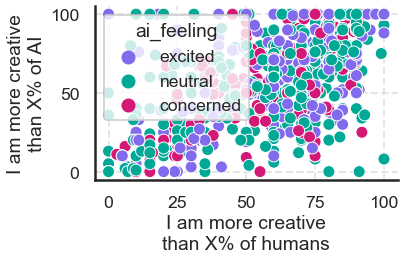

In [123]:
dfp['gap'] = dfp['creativity_ai'] - dfp['creativity_human']
sns.scatterplot(data=dfp, x="creativity_human", y="creativity_ai", hue='ai_feeling')
plt.xlabel("I am more creative\nthan X% of humans")
plt.ylabel("I am more creative\nthan X% of AI")

dfp.corr()

# Race conditions/trials

In [124]:
import pandas as pd
df = pd.read_csv("../../data/experiment_data/data_clean.csv")
counts = df.groupby(by=['response_chain', 'item', 'condition']).count().reset_index()[['response_chain', 'item', 'condition', 'response_id']]
counts = counts.rename(columns = {'response_id':'trials'})
counts.head()

,response_chain,item,condition,trials
0,0,bottle,f_l,19
1,0,bottle,f_u,16
2,0,bottle,h,19
3,0,bottle,m_l,18
4,0,bottle,m_u,19


In [125]:
desc = counts.describe()['trials']
print(desc)
print()
print(f"The average number of trials per response chain was {np.round(desc['mean'],2)} (SD = {np.round(desc['std'],2)}) and median number per chain was {int(desc['50%'])}. \
We concluded the experiment before the last round of response chains was completely finished for all condition X item\
 combinations so the minimum number of trials in a response chain (occuring for an item X condition combination in the last round) was {int(desc['min'])}. \
The maximum number of trials was {int(desc['max'])}" )

count    175.000000
mean      19.474286
std        1.575010
min       13.000000
25%       19.000000
50%       20.000000
75%       20.000000
max       24.000000
Name: trials, dtype: float64

The average number of trials per response chain was 19.47 (SD = 1.58) and median number per chain was 20. We concluded the experiment before the last round of response chains was completely finished for all condition X item combinations so the minimum number of trials in a response chain (occuring for an item X condition combination in the last round) was 13. The maximum number of trials was 24


In [126]:
import statsmodels.api as sm
from statsmodels.formula.api import ols


def anova_summary(anova_table):
    summary = {}
    summary_str = "Number of trials was not related to "
    for index in anova_table.index:
        F = anova_table.loc[index, "F"]
        df = int(anova_table.loc[index, "df"])
        p_value = anova_table.loc[index, "PR(>F)"]
        summary[index] = f'F({df}) = {F:.2f}, p = {p_value:.2f}'
    for x in summary:
        x_clean = x.replace("C(", "").replace(")", "")
        if x_clean in ['item', 'condition', 'item:condition']:
            summary_str += f"{x_clean} $({summary[x]})$" + ","
    print(summary_str)
    return summary

# Two way anova for condition X item
model_two_way = ols('trials ~ C(item) + C(condition) + C(item):C(condition)', data=counts).fit()
anova_table_two_way = sm.stats.anova_lm(model_two_way, typ=3)
print(anova_table_two_way)
print()
summ = anova_summary(anova_table_two_way)


                           sum_sq     df           F        PR(>F)
Intercept             2681.285714    1.0  984.388112  8.775127e-68
C(item)                 10.742857    4.0    0.986014  4.170918e-01
C(condition)             0.971429    4.0    0.089161  9.857249e-01
C(item):C(condition)     5.565714   16.0    0.127710  9.999843e-01
Residual               408.571429  150.0         NaN           NaN

Number of trials was not related to item $(F(4) = 0.99, p = 0.42)$,condition $(F(4) = 0.09, p = 0.99)$,item:condition $(F(16) = 0.13, p = 1.00)$,
